In [1]:
import statistics
from collections import defaultdict
from tqdm.notebook import tqdm

import pyro
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(7)
pyro.set_rng_seed(0)
np.random.seed(19680801)

from pyro.infer import SVI, Trace_ELBO, Importance, EmpiricalMarginal
import torch.distributions.constraints as constraints
from pyro.optim import Adam
from math import exp
import time
# Constants
MAX_ABUNDANCE = 100

In [2]:
print(time.asctime())

Thu Dec 17 22:27:03 2020


In [3]:
# load data
data_path = "mapk3000_SDE.csv"

data = pd.read_csv(data_path)
num_samples = data.shape[0]

single_interaction_data = data[["a(p(Raf))","a(p(Mek))"]]

parent = single_interaction_data["a(p(Raf))"].to_numpy()
target = single_interaction_data["a(p(Mek))"].to_numpy()

In [4]:
# Log transformation
def transform_target_to_log(target):
    return np.log(target / (MAX_ABUNDANCE - target))


target_transformed_to_log = transform_target_to_log(target)


# parent_transformed_to_log = transform_parent_to_log(parent)
Features = np.vstack([parent, np.ones(len(parent))]).T

In [5]:
# Linear Regression - get slope and intercept
w, b = np.linalg.lstsq(Features, target_transformed_to_log, rcond=None)[0]

# # Define n and k
# n = m
# # c = -n log k, then k = exp(-c/n)
# k = np.exp(-c/n)

In [6]:
w,b

(0.02692836884748728, -0.7747277642530821)

In [7]:
# logistic regression
def sigmoid(x, w, b):
    #return np.array([1 / (1 + exp(-1*b0 + -1*b1*x)) for x in X])
    return MAX_ABUNDANCE / (1 + np.exp(-1*(w*x + b)))

predicted_target = sigmoid(parent, w, b)
print(predicted_target[:5])
print(target[:5])

[61.3957254  68.13948228 62.03197387 63.29195552 65.7568158 ]
[56 75 55 61 69]


In [8]:
def test_sigmoid(c):
    return MAX_ABUNDANCE / (1 + np.exp(-1*(c)))

In [9]:
print(test_sigmoid(80))
print(test_sigmoid(82))
print(test_sigmoid(84))

100.0
100.0
100.0


In [10]:
# Report mean squared error

mse = np.square(np.subtract(target, predicted_target)).mean()

print("Mean squared error on train:", mse)

Mean squared error on train: 23.728086429672295


In [11]:
residual_ratio = (target / predicted_target).mean()

In [12]:
residual_std = np.subtract(target, predicted_target).std()
print(residual_std)

parent_mean = parent.mean()
parent_std = parent.std()

4.869198156214205


In [13]:
# Pyro model
# sigmoid with noise
def sigmoid_with_residual_noise(x, w, b, noise):
    return MAX_ABUNDANCE / (1 + np.exp(-1*(w*x + b + noise)))

# pyro model
def model(n_erk):
    noise = pyro.sample("n_Raf", n_erk)
    mek = pyro.sample("Mek", pyro.distributions.Normal(parent_mean, parent_std))
    
#     erk_mean = sigmoid_with_residual_noise(mek.detach().numpy(), w, b, noise.detach().numpy())
    erk_mean = sigmoid(mek.detach().numpy(), w, b)+noise
    erk = pyro.sample("Erk", pyro.distributions.Normal(torch.tensor(erk_mean), torch.tensor(1.0)))
    return mek,erk

In [14]:
n_erk = pyro.distributions.Normal(torch.tensor(0.0), torch.tensor(residual_std))
samples = torch.tensor([model(n_erk) for _ in range(3000)])

<ipython-input-13-72b7834c07cc>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  erk = pyro.sample("Erk", pyro.distributions.Normal(torch.tensor(erk_mean), torch.tensor(1.0)))


In [15]:
samples[:5]

tensor([[47.6735, 67.7828],
        [43.7475, 61.3177],
        [53.2886, 67.1763],
        [46.1687, 59.7214],
        [54.5917, 61.4728]], dtype=torch.float64)

In [16]:
print(sigmoid_with_residual_noise(60, w, b, 0.5))
print(sigmoid_with_residual_noise(60, w, b, -0.5))
print(sigmoid_with_residual_noise(60, w, b, -1))
print(sigmoid_with_residual_noise(60, w, b, -2))

79.26501300054343
58.44271887979915
46.032716412909416
23.88443777259134


In [17]:
#counterfactual
def infer_using_svi(conditioned_model, n_erk):

    def guide(n_erk):
        mu_constraints = constraints.interval(0., 5.)
        sigma_constraints = constraints.interval(.1, 7.)
        mu_guide = pyro.param("mu_n_Mek", torch.tensor(0.0), constraint=mu_constraints)
        sigma_guide = pyro.param("sigma_n_Mek", torch.tensor(residual_std),
                                     constraint=sigma_constraints)
        pyro.sample("n_Mek", pyro.distributions.Normal(mu_guide, sigma_guide))

    pyro.clear_param_store()

    svi = SVI(
        model=conditioned_model,
        guide=guide,
        optim=Adam({"lr": 0.0005, "betas": (0.95, 0.999)}),
        loss=Trace_ELBO(retain_graph=True)
    )
    losses = []
    num_steps = 1000
    samples = defaultdict(list)
    for t in tqdm(range(num_steps)):
        loss = svi.step(n_erk)
        #print(t, loss)
        losses.append(loss)
        mu = 'mu_n_Mek'
        sigma = 'sigma_n_Mek'
        samples[mu].append(pyro.param(mu).item())
        samples[sigma].append(pyro.param(sigma).item())
    means = {k: statistics.mean(v) for k, v in samples.items()}

    updated_noise = {}
    updated_noise = pyro.distributions.Normal(means["mu_n_Mek"], means["sigma_n_Mek"])

    return updated_noise, losses

In [18]:
def counterfactual_inference(intervened_mek):
    n_erk = pyro.distributions.Normal(0.0, torch.tensor(residual_std))

    # Generate a sample
    observed_mek, observed_erk = model(n_erk)

    print("Observed Raf:", observed_mek, "Observed Mek:", observed_erk)
    print("What would happen to Mek if Raf was", intervened_mek, "?")
    conditioned_model = pyro.condition(model, data={"Raf": observed_mek, "Mek": observed_erk})
    updated_n_erk = infer_using_svi(conditioned_model, n_erk)

    intervention_model = pyro.do(model, data={"Raf":torch.tensor(intervened_mek)})
    return intervention_model, updated_n_erk[0]

In [19]:
intervened_model_1, noise_1 = counterfactual_inference(60.)
intervened_model_2, noise_2 = counterfactual_inference(80.)

counterfactual_erk_1 = torch.tensor([intervened_model_1(noise_1)[1] for _ in range(1000)])
counterfactual_erk_2 = torch.tensor([intervened_model_2(noise_2)[1] for _ in range(1000)])

Observed Raf: tensor(47.9059) Observed Mek: tensor(68.5749, dtype=torch.float64)
What would happen to Mek if Raf was 60.0 ?


<ipython-input-13-72b7834c07cc>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  erk = pyro.sample("Erk", pyro.distributions.Normal(torch.tensor(erk_mean), torch.tensor(1.0)))



Observed Raf: tensor(39.1182) Observed Mek: tensor(53.3911, dtype=torch.float64)
What would happen to Mek if Raf was 80.0 ?


In [20]:
print("Counterfactual Erk when Mek = 60:: Mean", counterfactual_erk_1.mean(), counterfactual_erk_1.std())
print("Counterfactual Erk when Mek = 80:: Mean", counterfactual_erk_2.mean(), counterfactual_erk_2.std())

Counterfactual Erk when Mek = 60:: Mean tensor(63.4413) tensor(6.1788)
Counterfactual Erk when Mek = 80:: Mean tensor(63.5093) tensor(6.0826)


# Parent and Target Visualizations

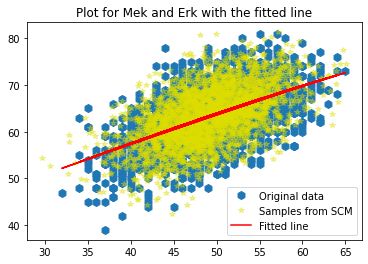

In [21]:
#parent -> Mek, target -> Erk
_ = plt.plot(parent, target, 'h',label='Original data', markersize=8)
_ = plt.plot(samples[:,0], samples[:,1], '*',alpha=0.4,label='Samples from SCM',color='#dede00')
_ = plt.plot(parent, predicted_target, 'r', label='Fitted line')
_ = plt.legend()
_ = plt.title("Plot for Mek and Erk with the fitted line")
plt.show()

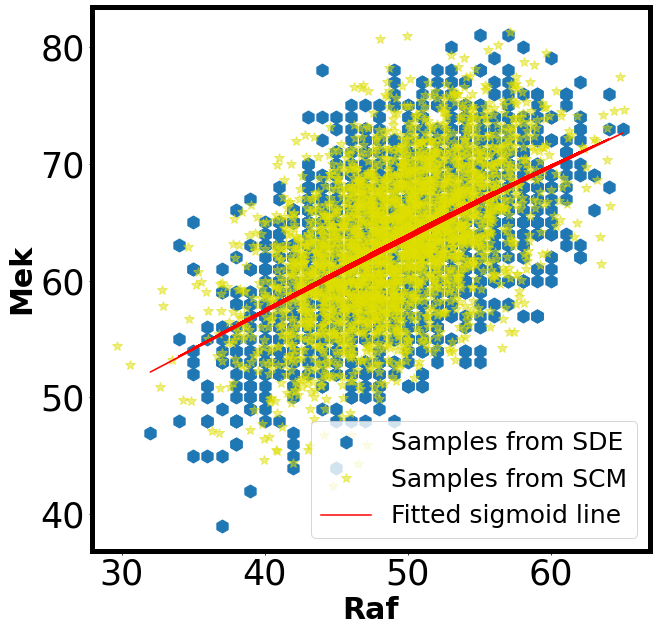

In [22]:
##### parent -> Raf, target -> Mek
fig = plt.figure(figsize=(10,10),frameon=True)
fig = plt.rcParams["axes.edgecolor"] = 'black'
fig = plt.rcParams["axes.linewidth"] = 5
fig = plt.plot(parent, target, 'h',label='Samples from SDE', markersize=13)
fig = plt.plot(samples[:,0], samples[:,1], '*',alpha=0.5,label='Samples from SCM',color='#dede00',markersize=11)
fig = plt.plot(parent, predicted_target, 'r', label='Fitted sigmoid line')
fig = plt.legend(fontsize=25)
fig = plt.xlabel("Raf",fontsize=30,weight='bold')
fig = plt.ylabel("Mek",fontsize=30,weight='bold')
fig = plt.tick_params(labelsize=35)
fig = plt.savefig('Raf_Mek_distribution_data.pdf')
fig = plt.savefig('Raf_Mek_distribution_data.png')

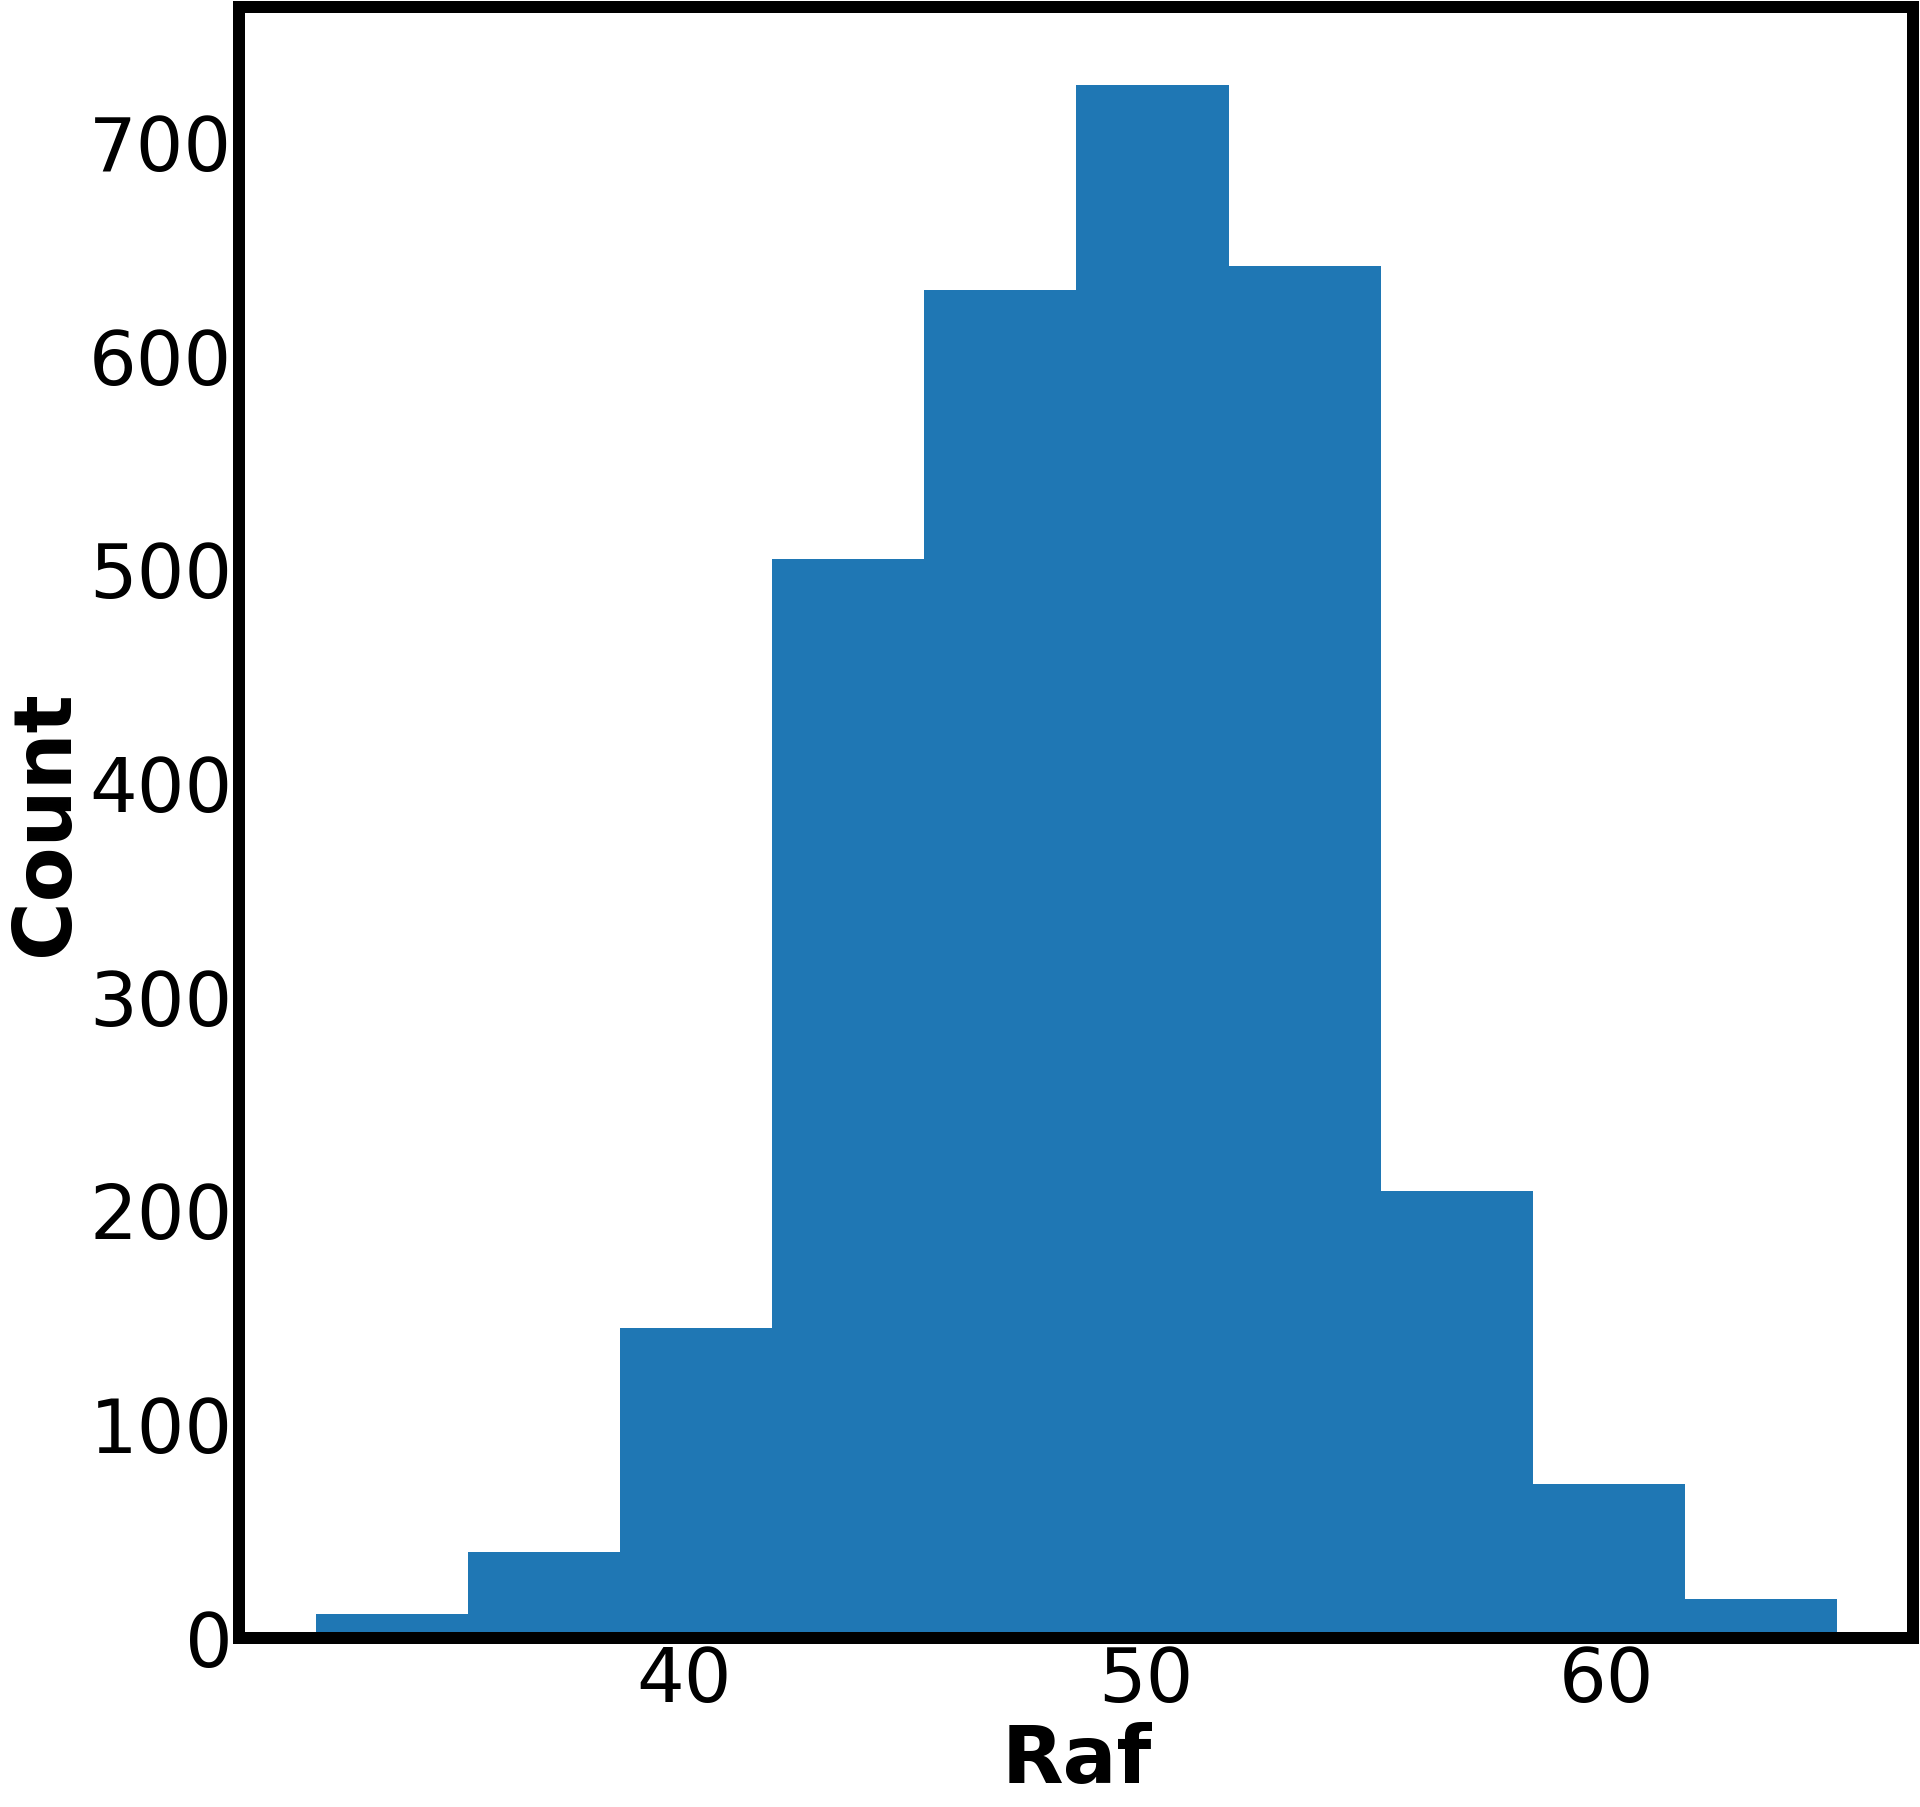

In [23]:
fig1 = plt.rcParams["figure.figsize"]=30.0,30.0
fig1 = plt.rcParams["figure.frameon"]=True
fig1 = plt.rcParams["axes.edgecolor"] = 'black'
fig1 = plt.rcParams["axes.linewidth"] = 12
fig1 = plt.xlabel("Raf",fontsize=80,weight='bold')
fig1 = plt.ylabel("Count",fontsize=80,weight='bold')
fig1 = plt.tick_params(labelsize=75)
fig1=  plt.hist(parent)
fig1 = plt.savefig('Raf_hist.pdf')

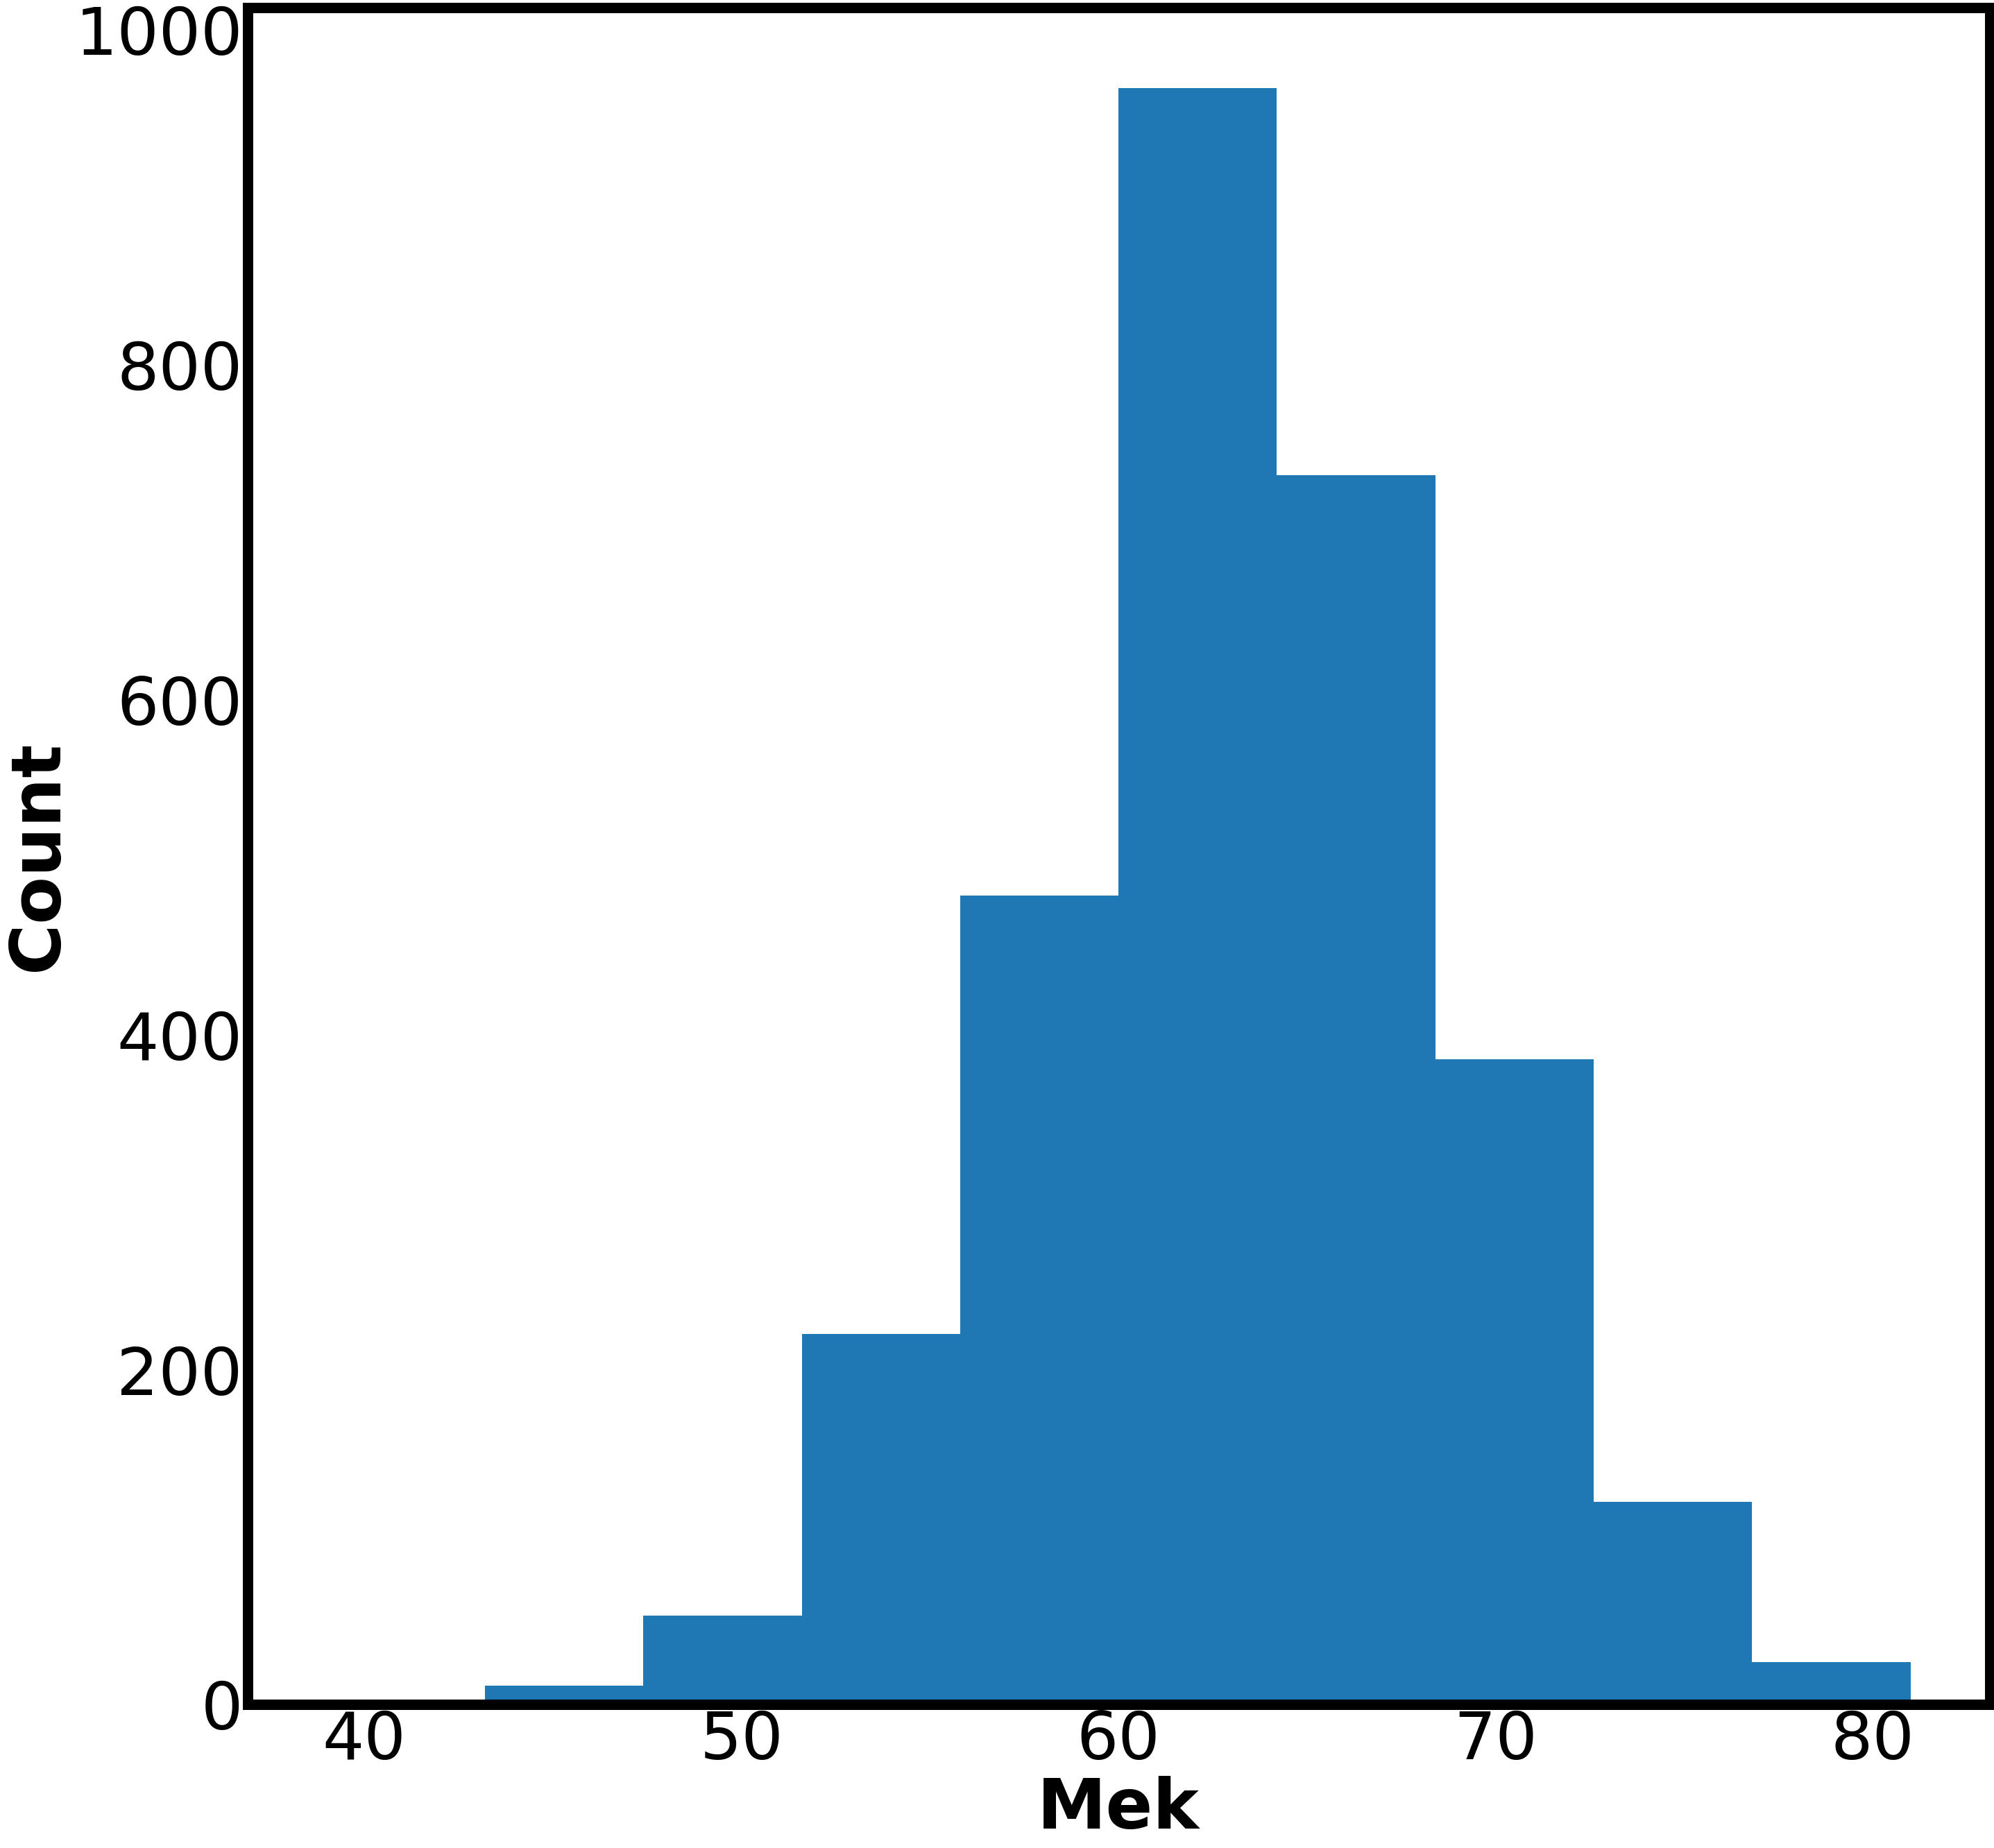

In [24]:
____ = plt.rcParams['figure.figsize']=45.0,45.0
____ = plt.rcParams['figure.frameon']=True
____ = plt.rcParams["axes.edgecolor"] = 'black'
____ = plt.rcParams["axes.linewidth"] = 15
____ = plt.xlabel("Mek",fontsize=100,weight='bold')
____ = plt.ylabel("Count",fontsize=100,weight='bold')
____ = plt.tick_params(labelsize=95)
____ = plt.hist(target)
____ = plt.savefig('Mek_hist.pdf')

# Visualisations for causal effects

In [25]:
igf_causal_data=pd.read_excel("Combined_CE (1).xlsx", engine='openpyxl')

In [26]:
igf_causal_data.shape

(5000, 8)

In [27]:
igf_causal_data.describe()

,SCM Causal Effect,SDE Observed,SDE Intervened,SDE Causal Effect,ODE Observed,ODE Intervention,ODE Causal Effect,SCM Causal Effect ATE
count,5000.000000,5000.000000,5000.000000,5000.000000,1.000000,1.00000,1.000000,5000.000000
mean,-0.056776,88.606000,87.738600,0.867400,88.647308,87.86998,0.777329,-0.347936
std,1.949711,3.228692,3.433923,4.671251,NaN,NaN,NaN,5.321445
min,-6.497108,76.000000,73.000000,-15.000000,88.647308,87.86998,0.777329,-18.000435
25%,-1.323311,87.000000,85.000000,-2.000000,88.647308,87.86998,0.777329,-3.887136
50%,-0.074272,89.000000,88.000000,1.000000,88.647308,87.86998,0.777329,-0.323444
75%,1.215454,91.000000,90.000000,4.000000,88.647308,87.86998,0.777329,3.266836
max,5.970421,100.000000,98.000000,17.000000,88.647308,87.86998,0.777329,17.575584


In [28]:
import numpy as np
bins= range(-12, 27)

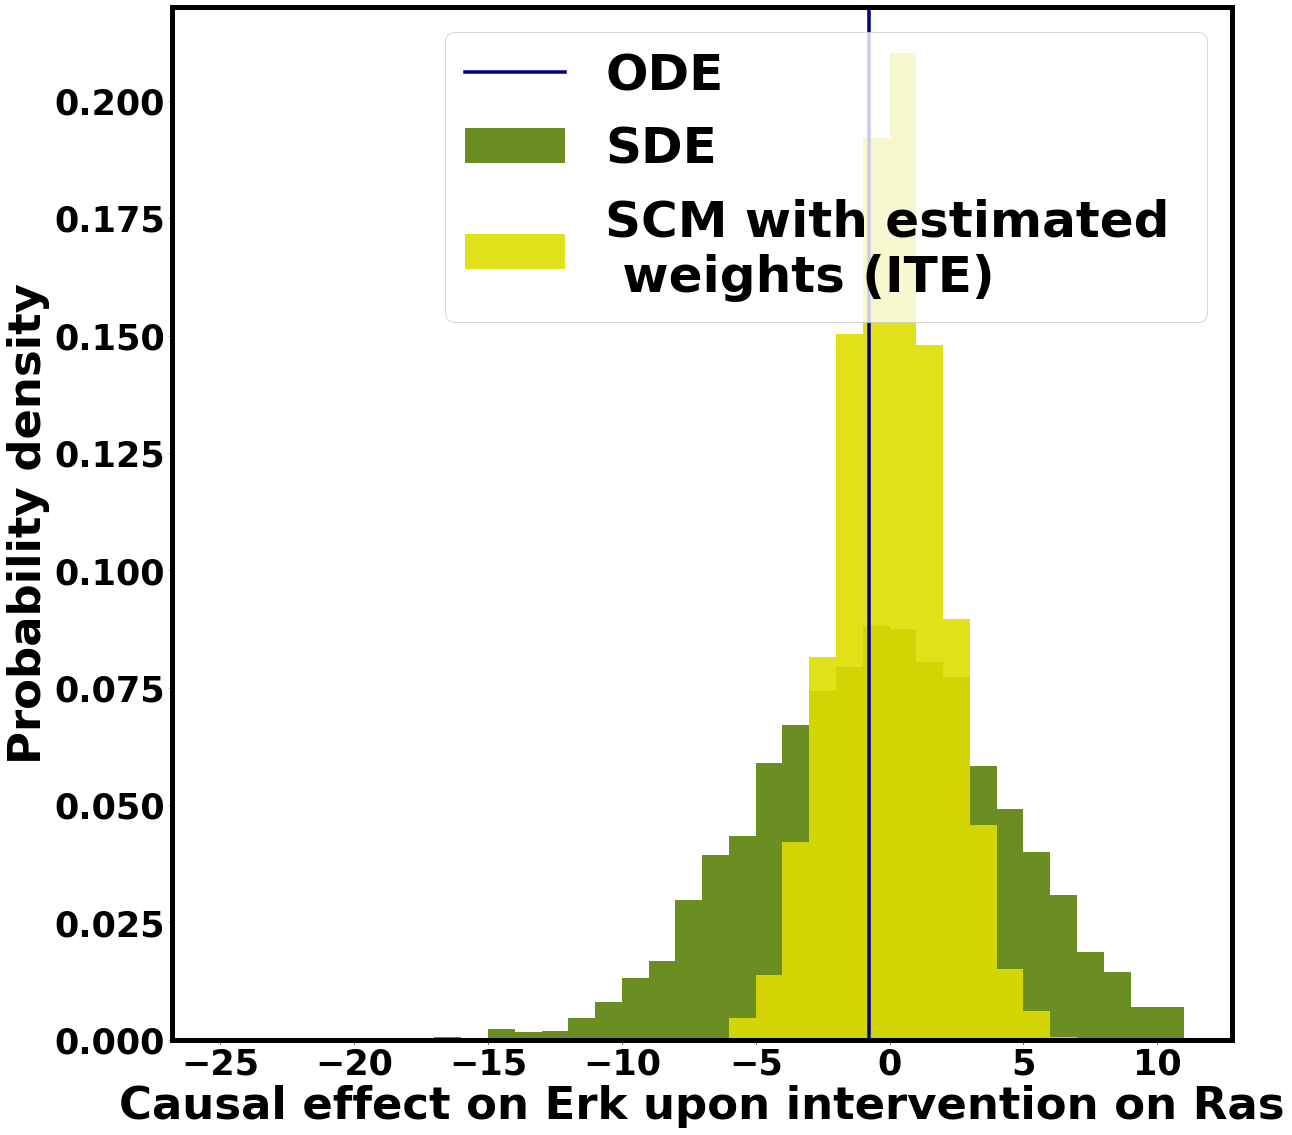

In [29]:
__ = plt.figure(figsize=(19,19))
__ = plt.rcParams["font.weight"] = "bold"
__ = plt.rcParams["axes.edgecolor"] = 'black'
__ = plt.rcParams["axes.linewidth"] = 5
__ = plt.hist(igf_causal_data['SDE Causal Effect']*(-1), bins= range(-25,12),label='SDE',color='olivedrab',density=True)
__ = plt.hist(igf_causal_data['SCM Causal Effect']*(-1), bins= range(-25,12), alpha=0.9, label='SCM with estimated \n weights (ITE)',color='#dede00',density=True)
__ = plt.axvline((-1)*igf_causal_data['ODE Causal Effect'].mean(), color='navy', linestyle='solid', linewidth=3.5,label='ODE')
__ = plt.xlabel("Causal effect on Erk upon intervention on Ras",fontsize=45,weight='bold')
__ = plt.ylabel("Probability density",fontsize=45,weight='bold')
__ = plt.legend(loc='upper right',fontsize=50)
__ = plt.tick_params(labelsize=35)
__ = plt.ylim(0.0,0.22)
__ = plt.savefig('igf_counterfactuals.pdf')

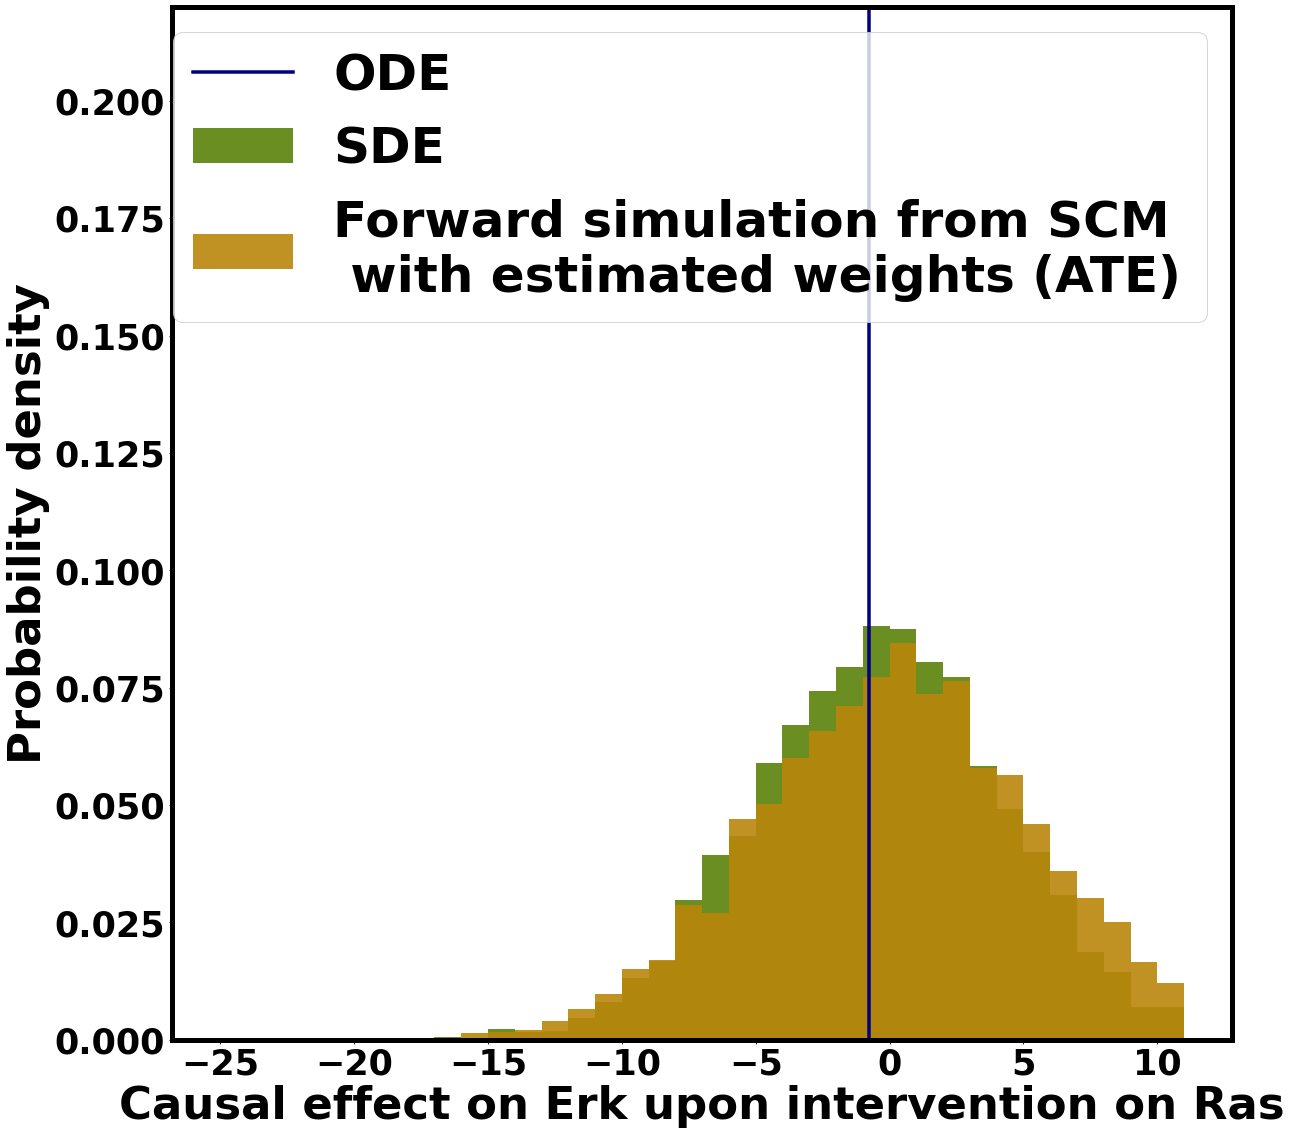

In [30]:
__ = plt.figure(figsize=(19,19))
__ = plt.rcParams["font.weight"] = "bold"
__ = plt.rcParams["axes.edgecolor"] = 'black'
__ = plt.rcParams["axes.linewidth"] = 5
__ = plt.hist(igf_causal_data['SDE Causal Effect']*(-1), bins= range(-25,12),label='SDE',color='olivedrab',density=True)
__ = plt.hist(igf_causal_data['SCM Causal Effect ATE']*(-1), bins= range(-25,12), alpha=0.9, label='Forward simulation from SCM \n with estimated weights (ATE)',color='darkgoldenrod',density=True)
__ = plt.axvline((-1)*igf_causal_data['ODE Causal Effect'].mean(), color='navy', linestyle='solid', linewidth=3.5,label='ODE')
__ = plt.xlabel("Causal effect on Erk upon intervention on Ras",fontsize=45,weight='bold')
__ = plt.ylabel("Probability density",fontsize=45,weight='bold')
__ = plt.legend(loc='upper right',fontsize=50)
__ = plt.tick_params(labelsize=35)
__ = plt.ylim(0.0,0.22)
__ = plt.savefig('igf_counterfactualsATE.pdf')

In [32]:
mapk_causal_data=pd.read_excel("MAPK_Combined_CE_Mek.xlsx", engine='openpyxl')

In [33]:
mapk_causal_data.describe()

,SCM Causal Effect,SDE Observed,SDE Intervened,SDE Causal Effect,ODE Observed,ODE Intervention,ODE Causal Effect,SCM Causal Effect ATE
count,5000.000000,3000.000000,3000.000000,3000.000000,1.000000,1.000000,1.000000,5000.000000
mean,7.215890,84.255333,76.318333,7.937000,84.721639,76.190476,8.531162,-7.923128
std,2.918630,3.894251,4.203675,5.724563,NaN,NaN,NaN,5.105425
min,-1.730576,68.000000,59.000000,-12.000000,84.721639,76.190476,8.531162,-28.515183
25%,5.239967,82.000000,74.000000,4.000000,84.721639,76.190476,8.531162,-11.365074
50%,7.204079,84.000000,76.000000,8.000000,84.721639,76.190476,8.531162,-7.898472
75%,9.229881,87.000000,79.000000,12.000000,84.721639,76.190476,8.531162,-4.466801
max,19.574638,96.000000,91.000000,26.000000,84.721639,76.190476,8.531162,13.035629


In [34]:
mapk_causal_data.shape

(5000, 8)

In [35]:
mapk_bins=range(-12,27) #blue #3182bd

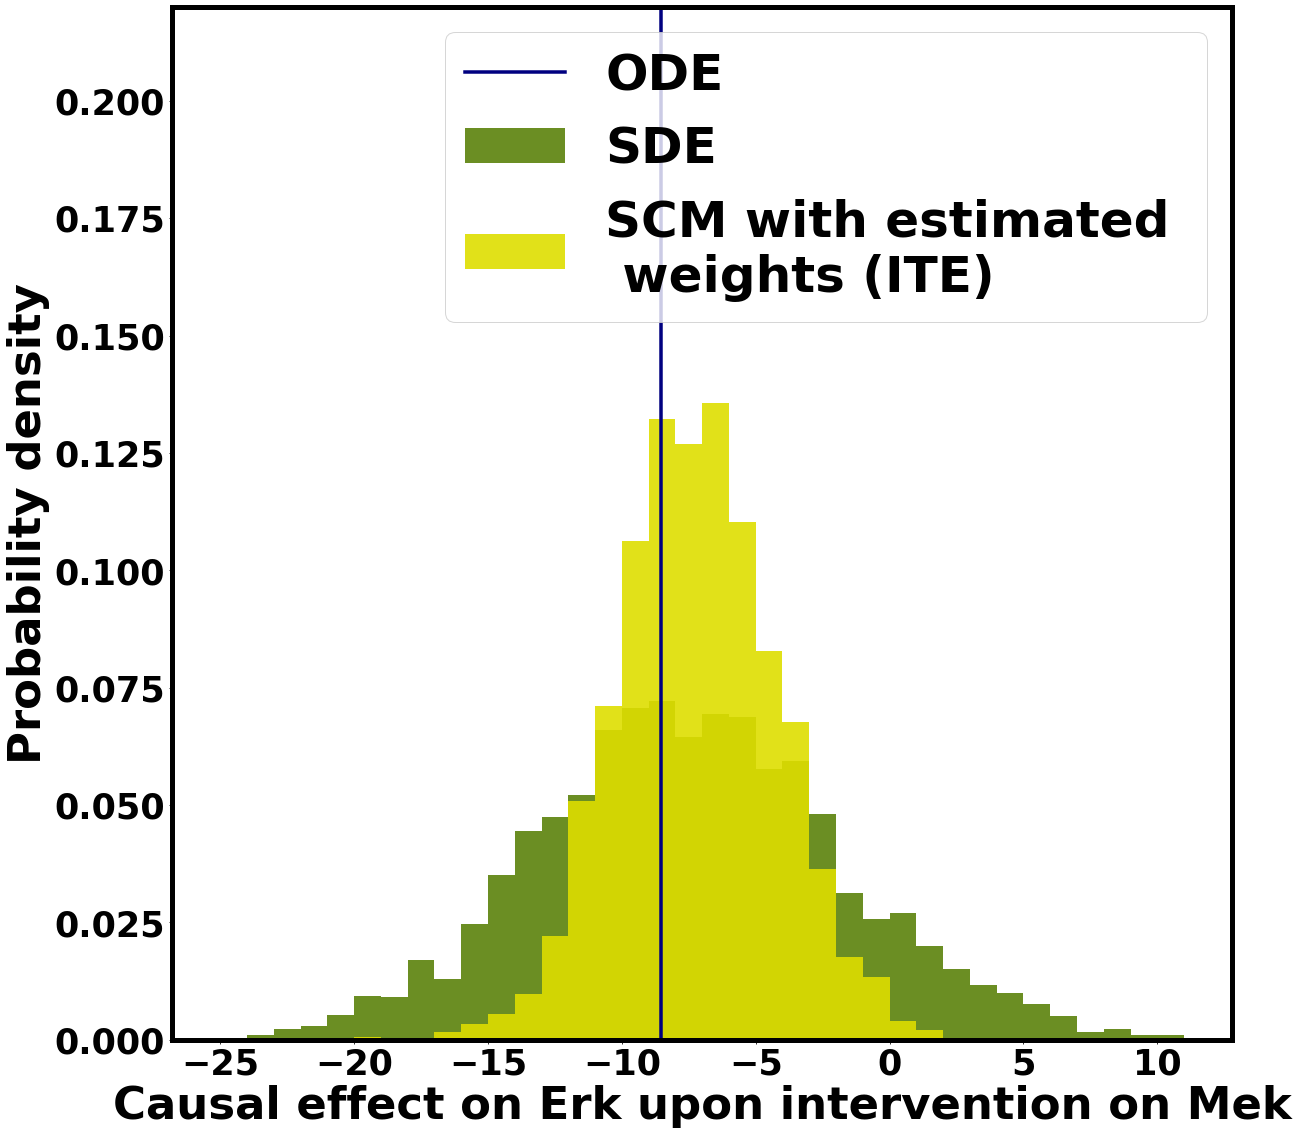

In [36]:
# histogram for mapk counterfactual
__m = plt.figure(figsize=(19,19))
__m = plt.rcParams["font.weight"] = "bold"
__m = plt.rcParams["axes.edgecolor"] = 'black'
__m = plt.rcParams["axes.linewidth"] = 5
__m = plt.hist(mapk_causal_data['SDE Causal Effect']*(-1) ,bins=range(-25,12), label='SDE',color='olivedrab',density=True)
__m = plt.hist(mapk_causal_data['SCM Causal Effect']*(-1),bins=range(-25,12),
               alpha=0.9,
               label='SCM with estimated \n weights (ITE)',color='#dede00',density=True)
__m = plt.axvline((-1)*mapk_causal_data['ODE Causal Effect'].mean(), color='navy', linestyle='solid', linewidth=3.5,label='ODE')
__m = plt.xlabel("Causal effect on Erk upon intervention on Mek",fontsize=45,weight='bold')
__m = plt.ylabel("Probability density",fontsize=45,weight='bold')
__m = plt.legend(loc='upper right',fontsize=50)
__m = plt.tick_params(labelsize=35)
__m = plt.ylim(0,0.22)
__m = plt.savefig('mapk_counterfactuals.pdf')

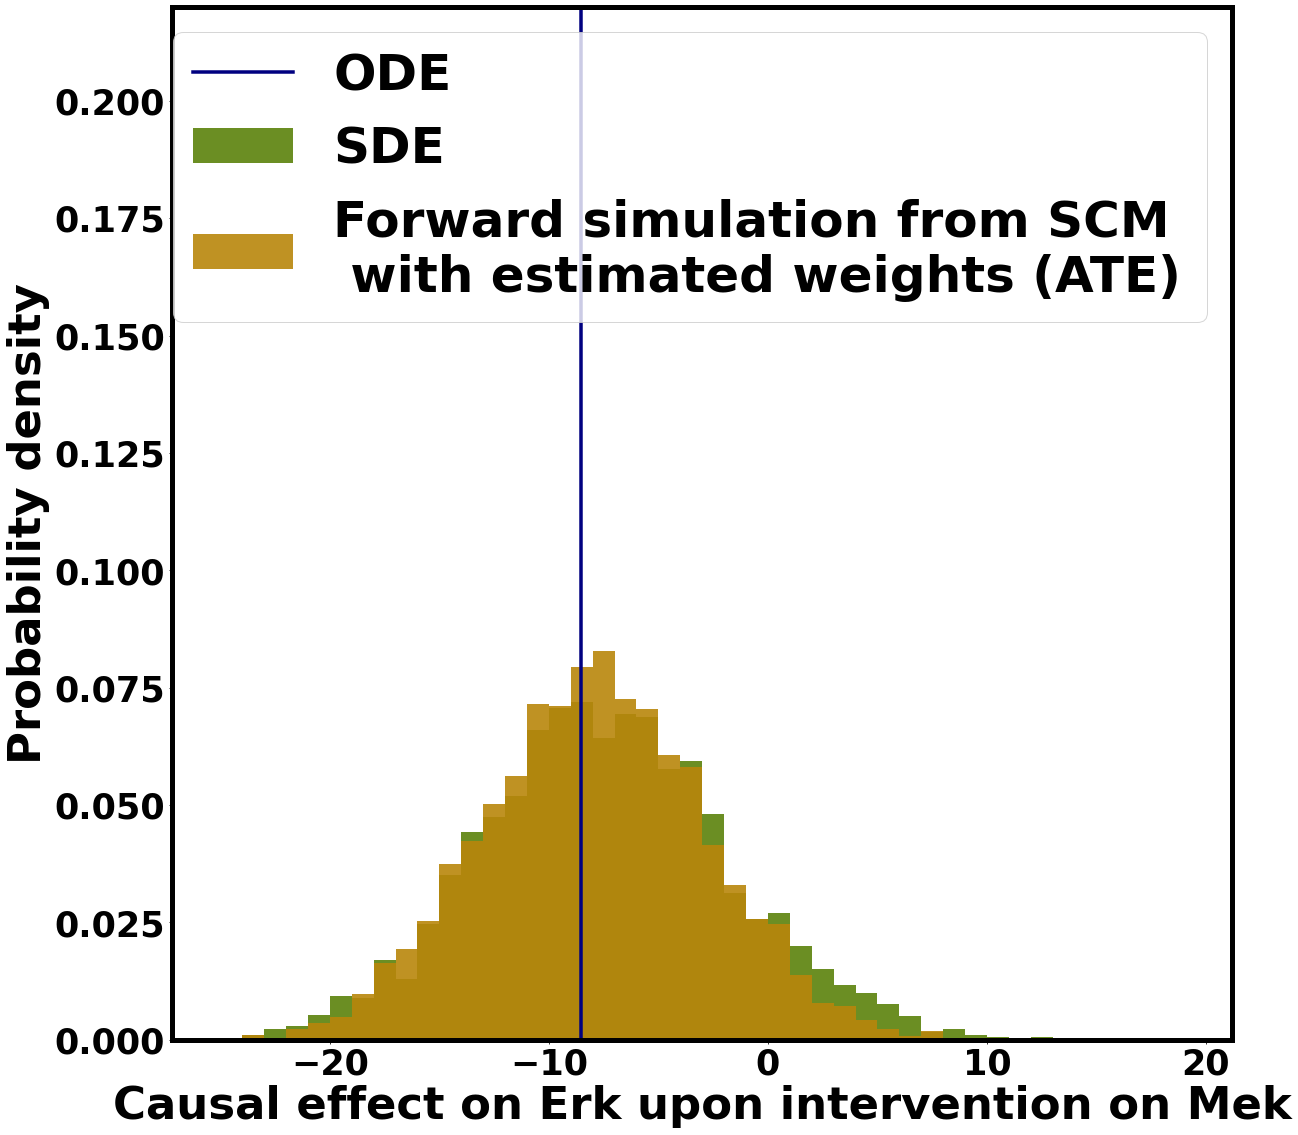

In [37]:
# histogram for mapk counterfactual
__m = plt.figure(figsize=(19,19))
__m = plt.rcParams["font.weight"] = "bold"
__m = plt.rcParams["axes.edgecolor"] = 'black'
__m = plt.rcParams["axes.linewidth"] = 5
__m = plt.hist(mapk_causal_data['SDE Causal Effect']*(-1) ,bins=range(-25,20), label='SDE',color='olivedrab',density=True)
__m = plt.hist(mapk_causal_data['SCM Causal Effect ATE']*(1),bins=range(-25,20),
               alpha=0.9,
               label='Forward simulation from SCM \n with estimated weights (ATE)',color='darkgoldenrod',density=True)
__m = plt.axvline((-1)*mapk_causal_data['ODE Causal Effect'].mean(), color='navy', linestyle='solid', linewidth=3.5,label='ODE')
__m = plt.xlabel("Causal effect on Erk upon intervention on Mek",fontsize=45,weight='bold')
__m = plt.ylabel("Probability density",fontsize=45,weight='bold')
__m = plt.legend(loc='upper right',fontsize=50)
__m = plt.tick_params(labelsize=35)
__m = plt.ylim(0,0.22)
__m = plt.savefig('mapk_counterfactualsATE.pdf')

In [38]:
igf_data=pd.read_csv("observational_igf.csv")

In [39]:
igf_data.head()

,Unnamed: 0,a(p(SOS)),a(p(Ras)),a(p(PI3K)),a(p(AKT)),a(p(Raf)),a(p(Mek)),a(p(Erk))
0,1,56,56,68,62,39,80,92
1,2,49,54,64,52,36,71,85
2,3,56,52,70,55,42,75,88
3,4,55,43,59,51,29,78,89
4,5,53,45,66,58,36,80,89


# Histograms for IGF root nodes

In [40]:
root_node_data=igf_data[["a(p(SOS))","a(p(PI3K))"]]
root_node1=root_node_data['a(p(SOS))'].to_numpy()
root_node2=root_node_data['a(p(PI3K))'].to_numpy()

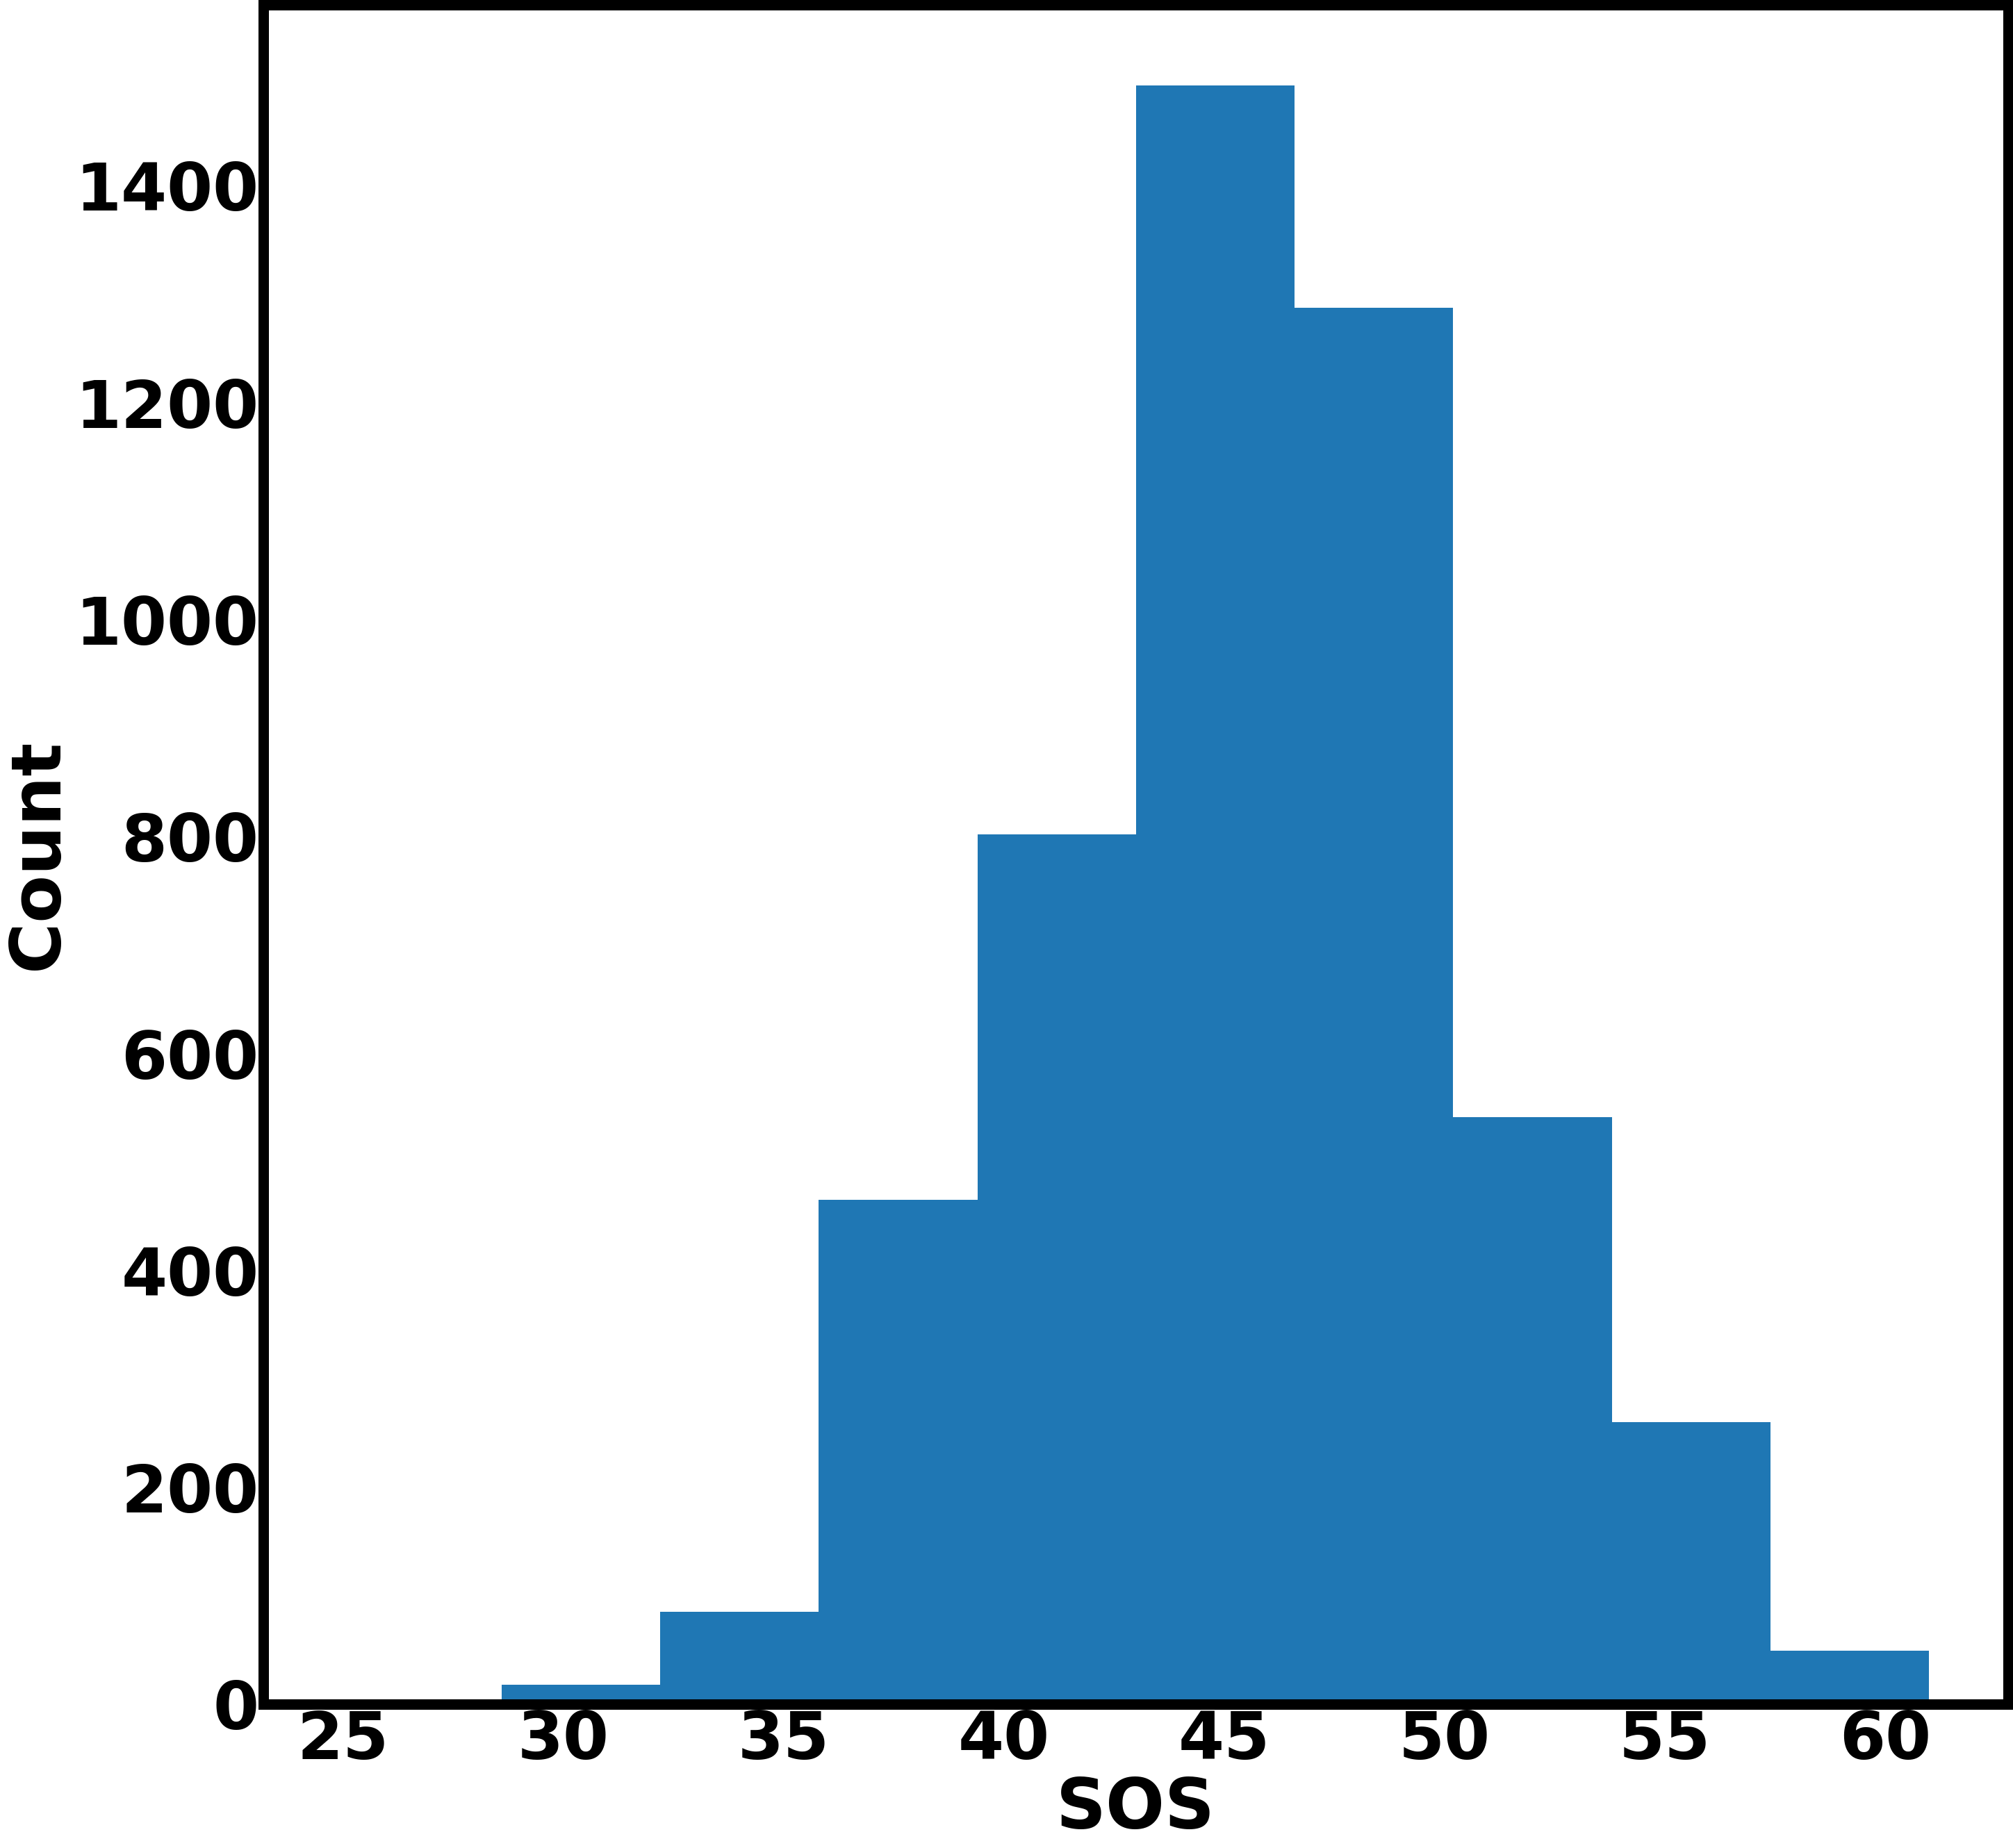

In [41]:
plt.rcParams['figure.figsize']=45.0,45.0
plt.rcParams['figure.frameon']=True
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["axes.linewidth"] = 15
plt.xlabel("SOS",fontsize=100,weight='bold')
plt.ylabel("Count",fontsize=100,weight='bold')
plt.tick_params(labelsize=95)
plt.hist(root_node1)
plt.savefig('Sos_hist.pdf')

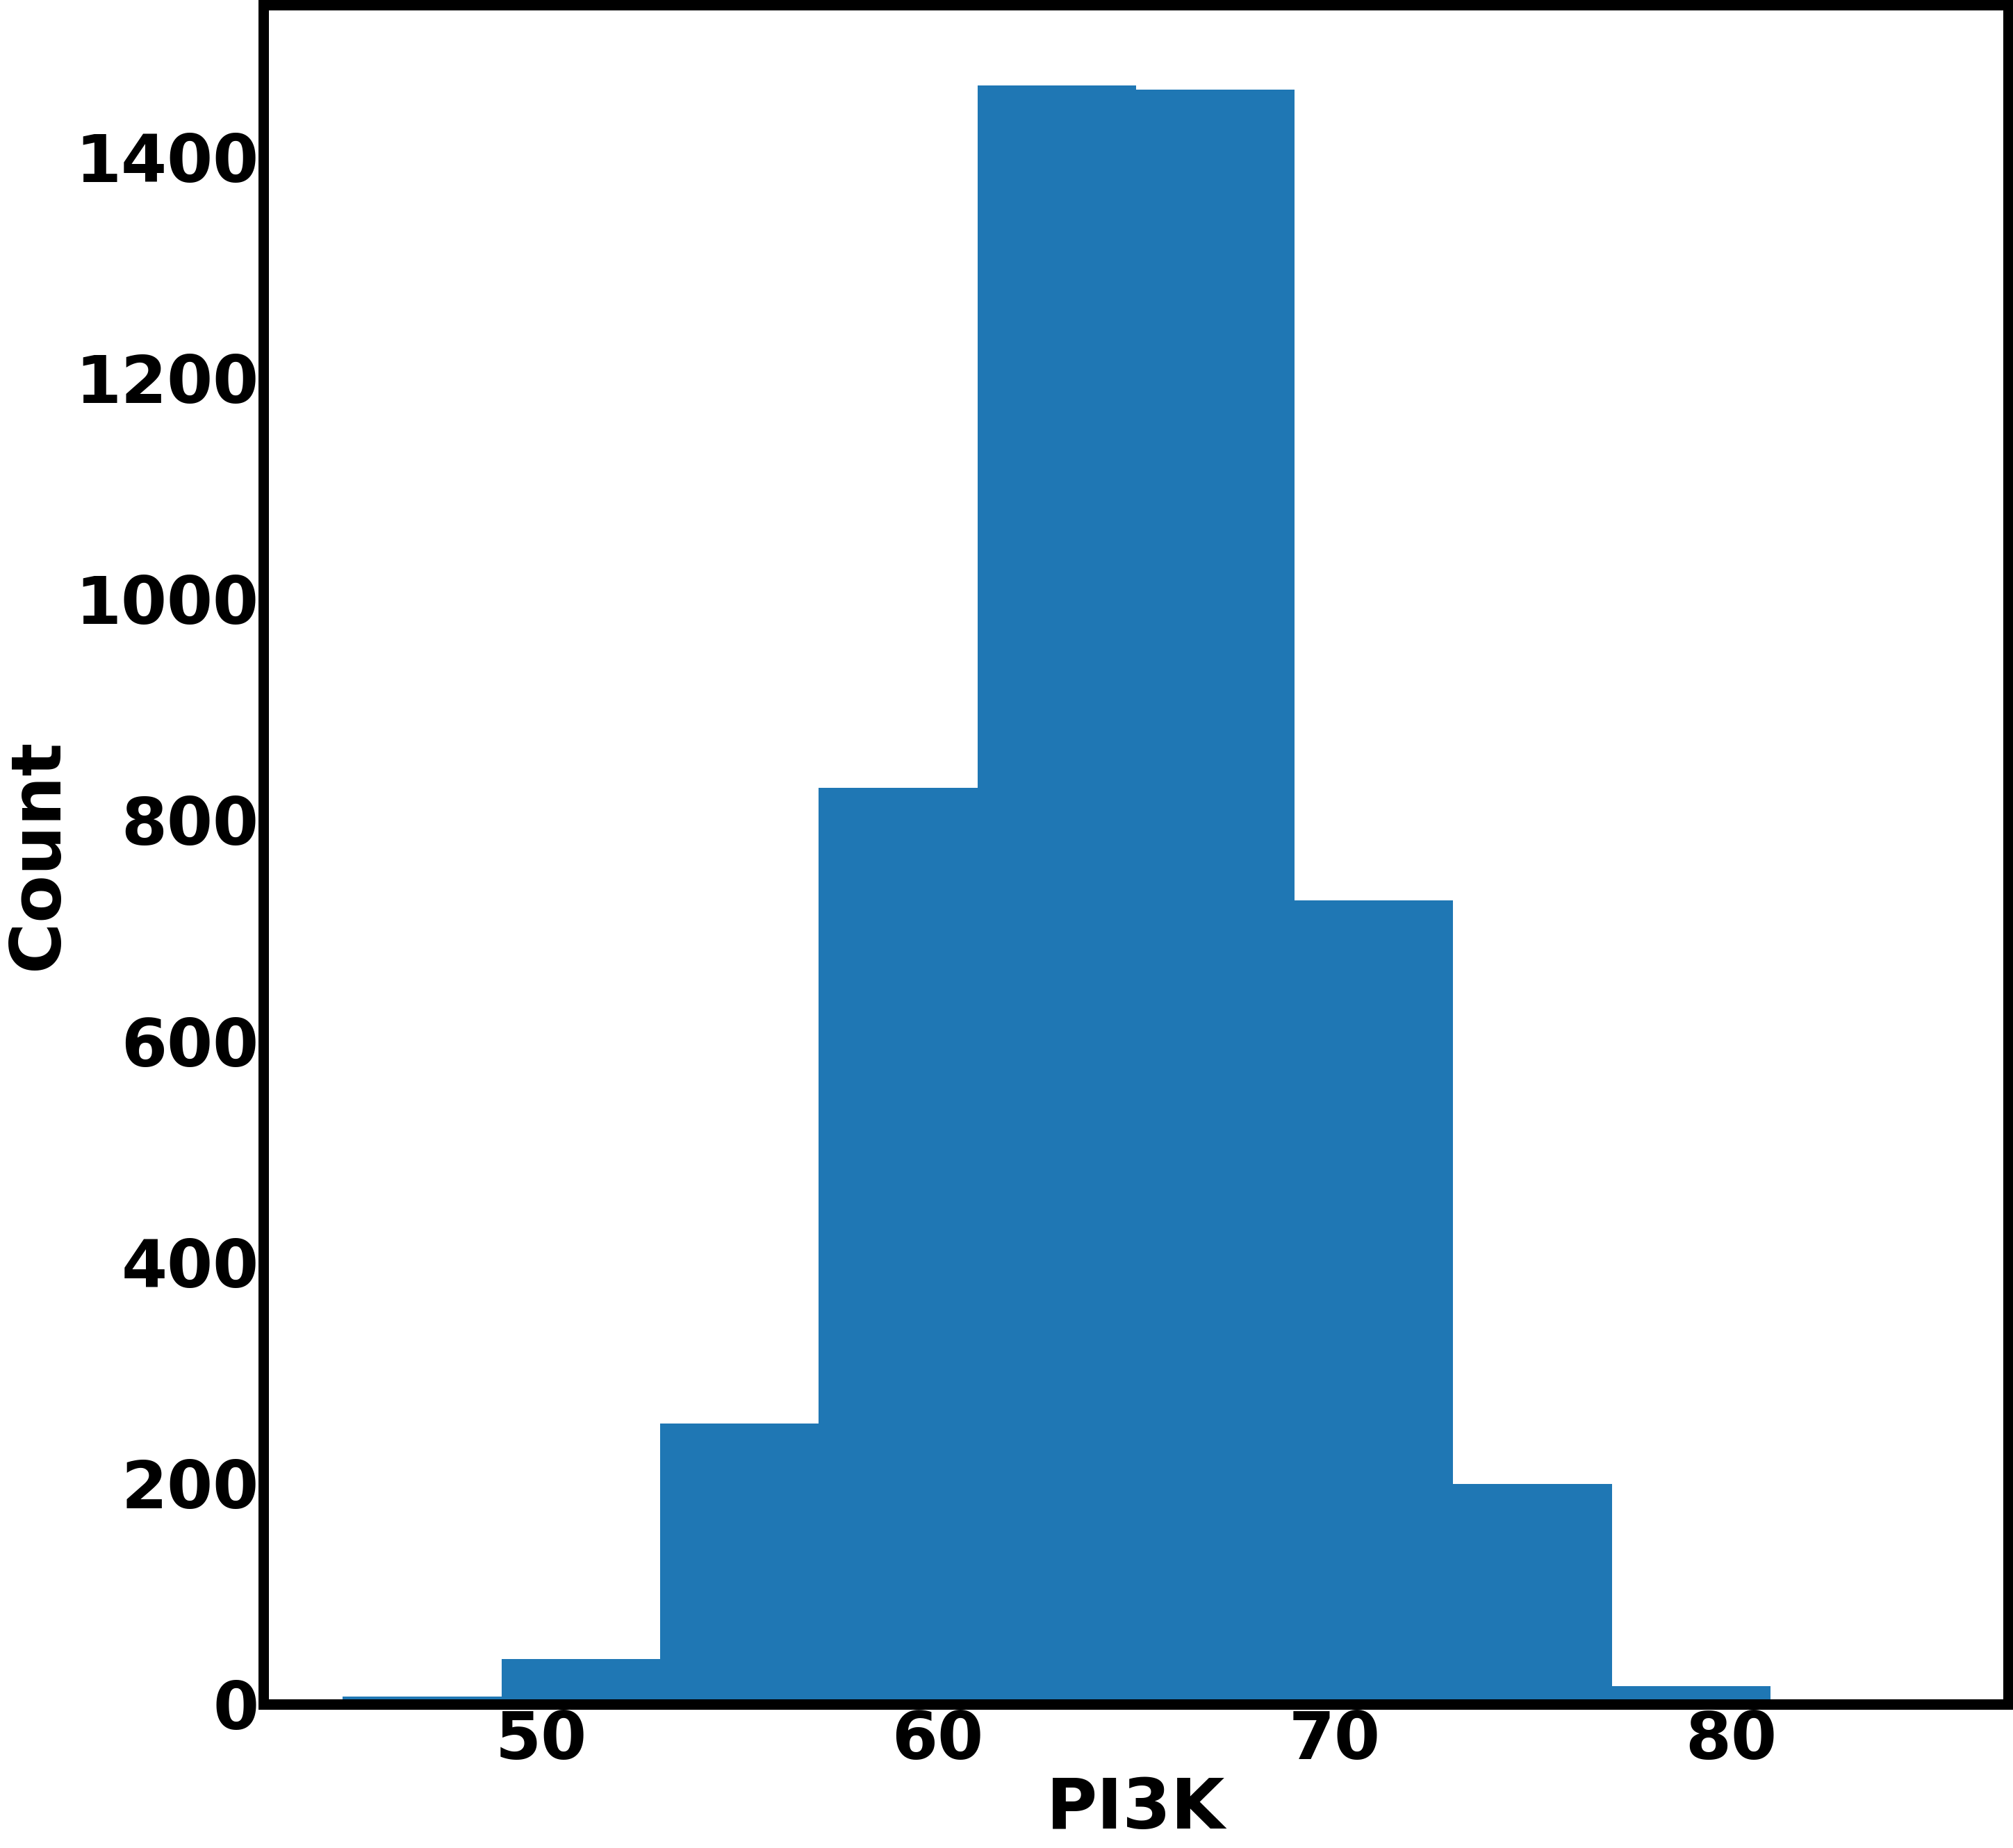

In [42]:
plt.rcParams['figure.figsize']=45.0,45.0
plt.rcParams['figure.frameon']=True
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["axes.linewidth"] = 15
plt.xlabel("PI3K",fontsize=100,weight='bold')
plt.ylabel("Count",fontsize=100,weight='bold')
plt.tick_params(labelsize=95)
plt.hist(root_node2)
plt.savefig('PI3k_hist.pdf')

# Visualizations for data generation vs bel2scm

In [43]:
causal_data_scm=pd.read_csv("covid_data_eq16_bel2scm.csv")

In [44]:
causal_data_mmscm=pd.read_csv("covid_data_eq16_dgscm.csv")

In [45]:
causal_data_scm.describe(),causal_data_mmscm.describe()

(                 0
 count  5000.000000
 mean      4.525775
 std       1.841620
 min       0.045990
 25%       3.242561
 50%       4.532707
 75%       5.829124
 max      10.296242,
                  0
 count  5000.000000
 mean      1.673626
 std       1.844222
 min      -5.952293
 25%       0.346390
 50%       1.668702
 75%       2.884934
 max       6.785134)

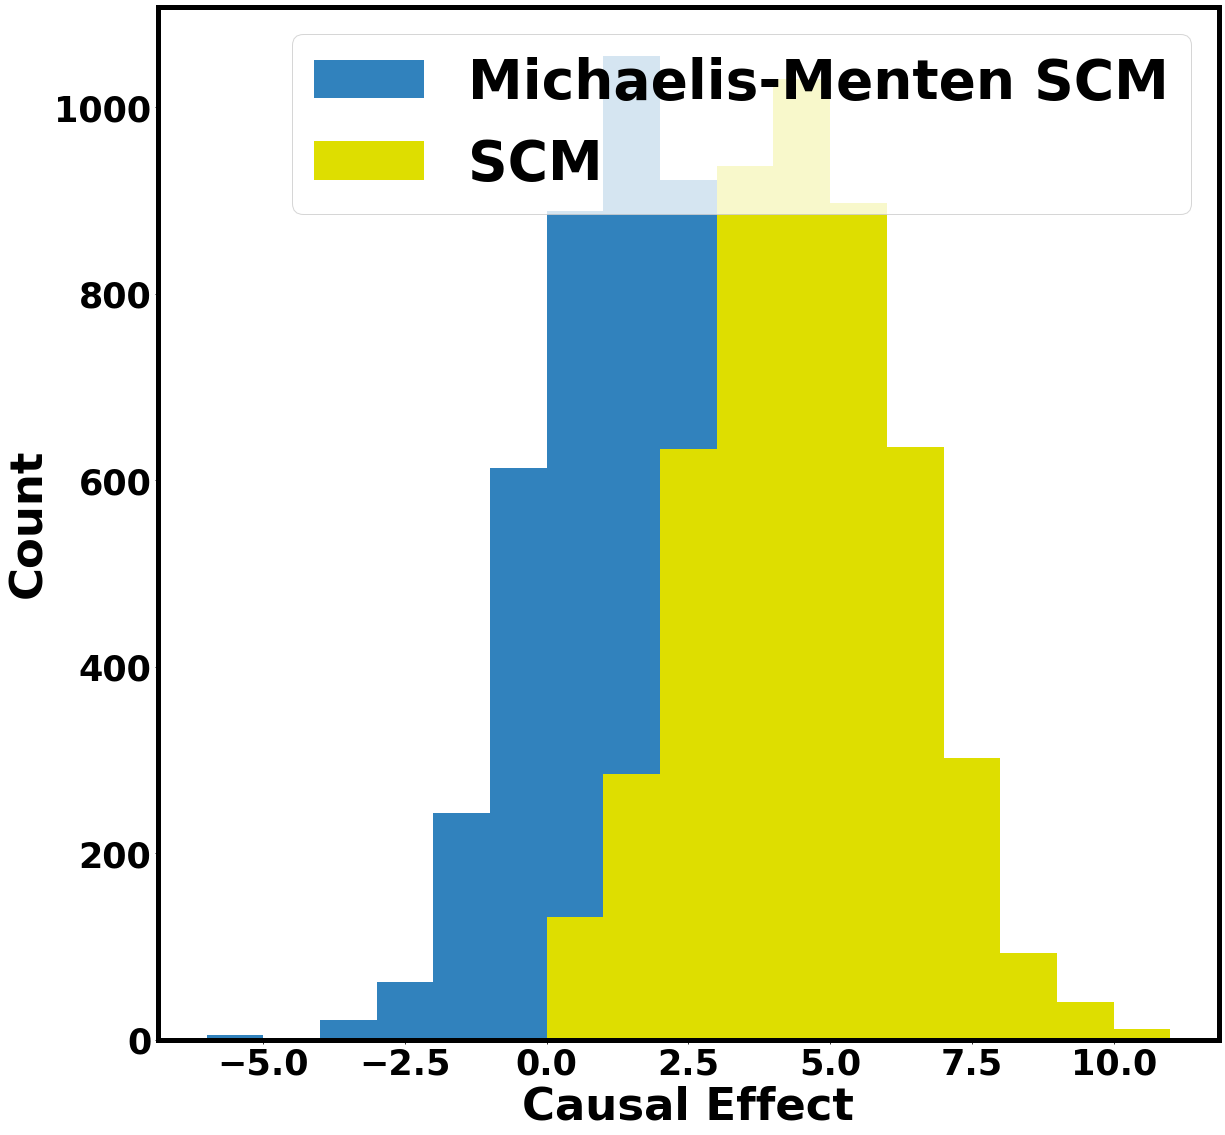

In [46]:
#histograms for causal effect eq 16
plt.figure(figsize=(19,19))
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["axes.linewidth"] = 5
plt.hist(causal_data_mmscm['0'] ,bins=range(-6,12), label='Michaelis-Menten SCM',color='#3182bd')
plt.hist(causal_data_scm['0'],bins=range(-6,12),
         #alpha=0.5,
         label='SCM',color='#dede00')
plt.xlabel("Causal Effect",fontsize=45,weight='bold')
plt.ylabel("Count",fontsize=45,weight='bold')
plt.legend(loc='upper right',fontsize=55)
plt.tick_params(labelsize=35)
plt.savefig('covid19_counterfactual1.pdf')

In [47]:
causal_effect_mmscmeq17=pd.read_csv("covid_data_eq17_dgscm (1).csv")
causal_effect_scmeq17=pd.read_csv("covid_data_eq17_bel2scm.csv")

In [48]:
causal_effect_mmscmeq17.describe(), causal_effect_scmeq17.describe()

(                 0
 count  5000.000000
 mean     -0.227071
 std       1.651737
 min      -6.997116
 25%      -1.346061
 50%      -0.202621
 75%       0.939499
 max       4.364235,
                  0
 count  5000.000000
 mean      5.107480
 std       1.852785
 min       0.061409
 25%       3.824921
 50%       5.112099
 75%       6.414619
 max      10.853722)

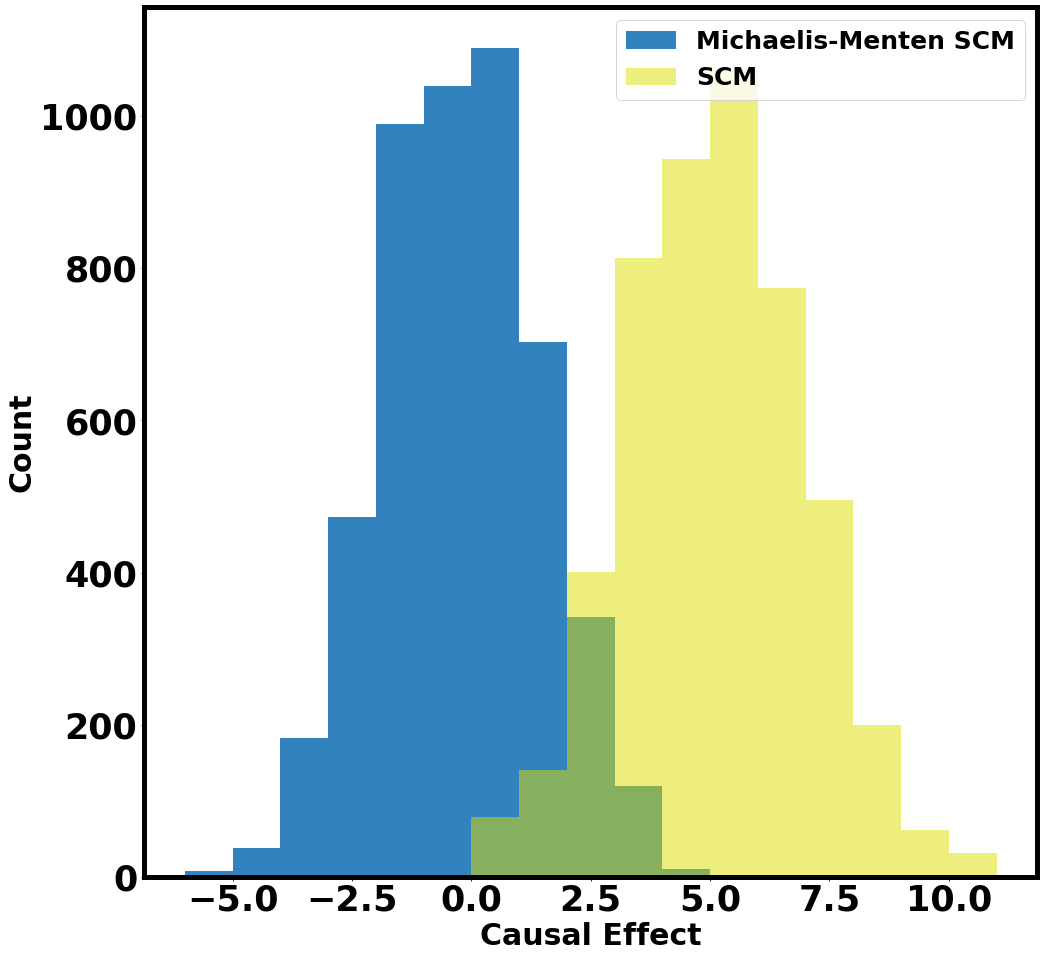

In [49]:
#histograms for causal effect eq 17
plt.figure(figsize=(16,16))
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["axes.linewidth"] = 5
plt.hist(causal_effect_mmscmeq17['0'] ,bins=range(-6,12), label='Michaelis-Menten SCM',color='#3182bd')
plt.hist(causal_effect_scmeq17['0'],bins=range(-6,12),alpha=0.5,label='SCM',color='#dede00')
plt.xlabel("Causal Effect",fontsize=30,weight='bold')
plt.ylabel("Count",fontsize=30,weight='bold')
plt.legend(loc='upper right',fontsize=25)
plt.tick_params(labelsize=35)
#plt.savefig('covid19_counterfactual2.pdf')

In [50]:
#histograms  without noise for eq16
eq16data_bel2scm= pd.read_csv("covid_data_sil6R0_noisy_bel2scm.csv")
eq16dta_dgscm=pd.read_csv("covid_data_sil6R0_noisy_dgscm.csv")

In [51]:
eq16data_bel2scm.describe(), eq16dta_dgscm.describe()

(                 0
 count  5000.000000
 mean      0.732414
 std       1.639978
 min      -4.223549
 25%      -0.358156
 50%       0.704048
 75%       1.876246
 max       6.040978,
                  0
 count  5000.000000
 mean      0.713330
 std       1.671836
 min      -3.827739
 25%      -0.431820
 50%       0.610768
 75%       1.812344
 max       5.668202)

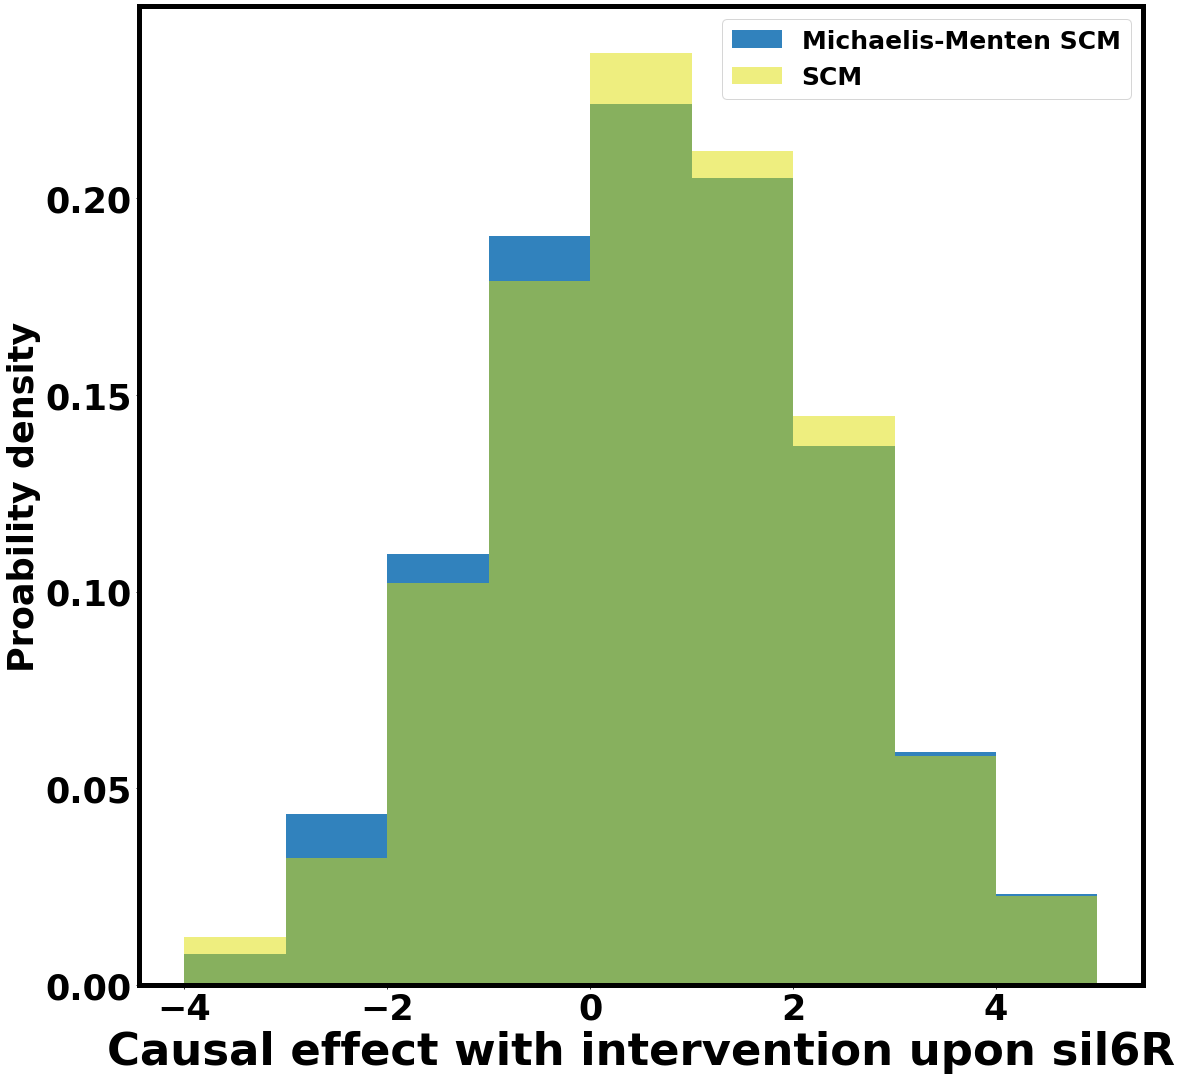

In [52]:
plt.figure(figsize=(18,18))
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["axes.linewidth"] = 5
plt.hist(eq16dta_dgscm['0'] ,bins=range(-4,6), label='Michaelis-Menten SCM',color='#3182bd',density=True)
plt.hist(eq16data_bel2scm['0'],bins=range(-4,6),alpha=0.5,label='SCM',color='#dede00',density=True)
plt.xlabel("Causal effect with intervention upon sil6R",fontsize=45,weight='bold')
plt.ylabel("Proability density",fontsize=35,weight='bold')
plt.legend(loc='upper right',fontsize=25)
plt.tick_params(labelsize=35)
#plt.savefig('covid19_counterfactual1.pdf')